In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 19/09/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [7]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
dali_path_old_project = '/dali/lgrandi/giovo/midway/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [8]:
file = dali_path_old_project + 'data_cut_new_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [9]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/cvmfs/xenon.opensciencegrid.org/releases/anaconda/2.4/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


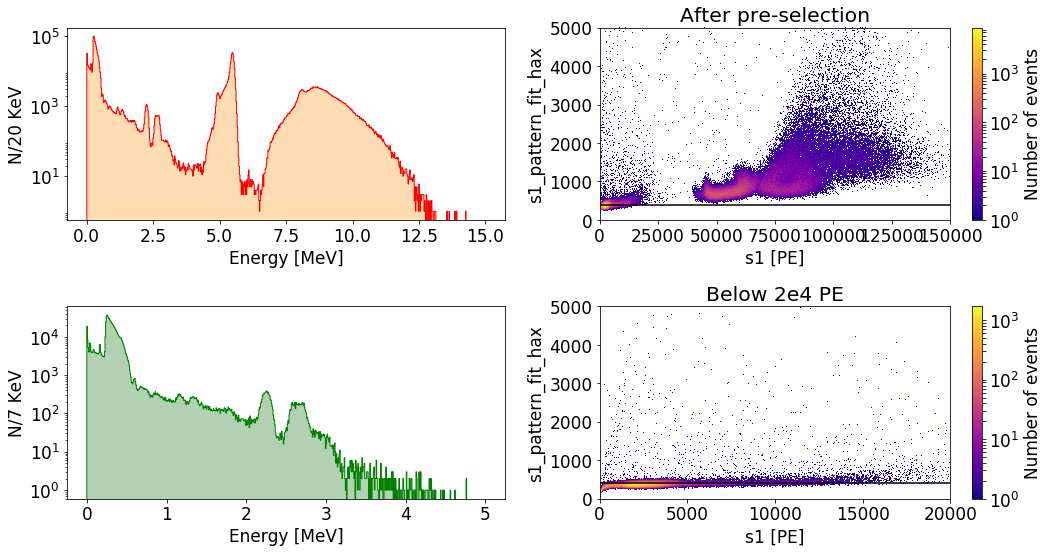

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N/20 KeV')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_hax'], bins = (1000, 400), 
           range=((0,1.5e5), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')
plt.hlines(y=400, xmax=1.5e5, xmin=0, colors='k', linestyles='solid')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.3)
plt.xlabel('Energy [MeV]')
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='step', color='green',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N/7 KeV')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 400), 
           range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')
plt.hlines(y=400, xmax=2e4, xmin=0, colors='k', linestyles='solid')


plt.tight_layout()
plt.show()

- Fei suggestion: check (S2/S1;S1) parameter space.

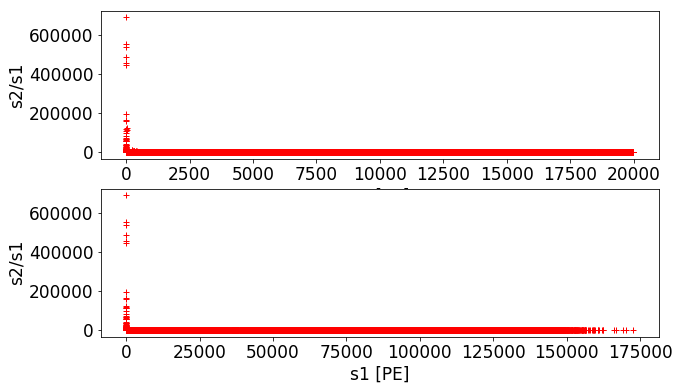

ValueError: max() arg is an empty sequence

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(211)
plt.plot(data['s1'], data['s2']/data['s1'], 'r+')
plt.xlabel('s1 [PE]')
plt.ylabel('s2/s1')

plt.subplot(212)
plt.plot(data_white['s1'], data_white['s2']/data_white['s1'], 'r+')
plt.xlabel('s1 [PE]')
plt.ylabel('s2/s1')

plt.show()
plt.tight_layout()

### Cut definition 

In [7]:
def S1PatternLikelihoodProfile_old(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

def S1PatternLikelihoodProfile_old_2(x, a, b, c, d):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5)

In [8]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def poly1(x, p0, p1):
    return p0 + p1 * x

def poly2(x, p0, p1, p2):
    return p0 + p1 * x + p2 * x**2

def poly3(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3

def poly1_3(x, p0, p1, p3):
    return p0 + p1 * x + p3 * x**3

def exp(x, p0, p1, p3):
    return p0 + p1 *np.exp(-p3*x)

def S1PatternLikelihoodProfile_new(x, p0, p1, p2, p3, p4, p5):
    return poly5(x, p0, p1, p2, p3, p4, p5)

In [9]:
from statsmodels.stats.proportion import proportion_confint
binomial_error_method = 'wilson'
binomial_alpha = 0.68


def acceptance(data_before, data_after):
    after, bins=np.histogram(data_after ,bins=Bins, range=hist_range)
    before, bins=np.histogram(data_before ,bins=Bins, range=hist_range)

    acceptance = after/before
    error = proportion_confint(after, before, method=binomial_error_method, alpha=binomial_alpha)
    err_low = error[0]
    err_high = error[1]
    yerr_low, yerr_high = (acceptance - err_low, err_high - acceptance)
    err = (yerr_low, yerr_high)

    plt.errorbar(binn, acceptance, err,0, marker='.', markersize=5, linestyle="", linewidth=0.5, color='navy')
    plt.axhline(y=1, color='k',linestyle='--')
    plt.ylabel('acceptance')
    plt.ylim(0,1.05)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

# On z

In [10]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_hax'],
                                         bins=(100,800), 
                                         range=((-83.45, -13.45), (0.0,1000))
                                         )

ybins_center_z = np.asarray([0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)])
xbins_center_z = np.asarray([0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)])

#perc_1 = np.empty(len(xbins_center_1))
#for i in tqdm(range(len(hist_1))):
perc_z = percentile_numeric(hist = hist_1, xbins= xbins_1, ybins = ybins_1, q=0.98)
    #perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.997, var1='s1', var2='s1 patter fit hax')
    
#xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
#xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit
del hist_1, xbins_1, ybins_1

100%|██████████| 100/100 [00:00<00:00, 1305.56it/s]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


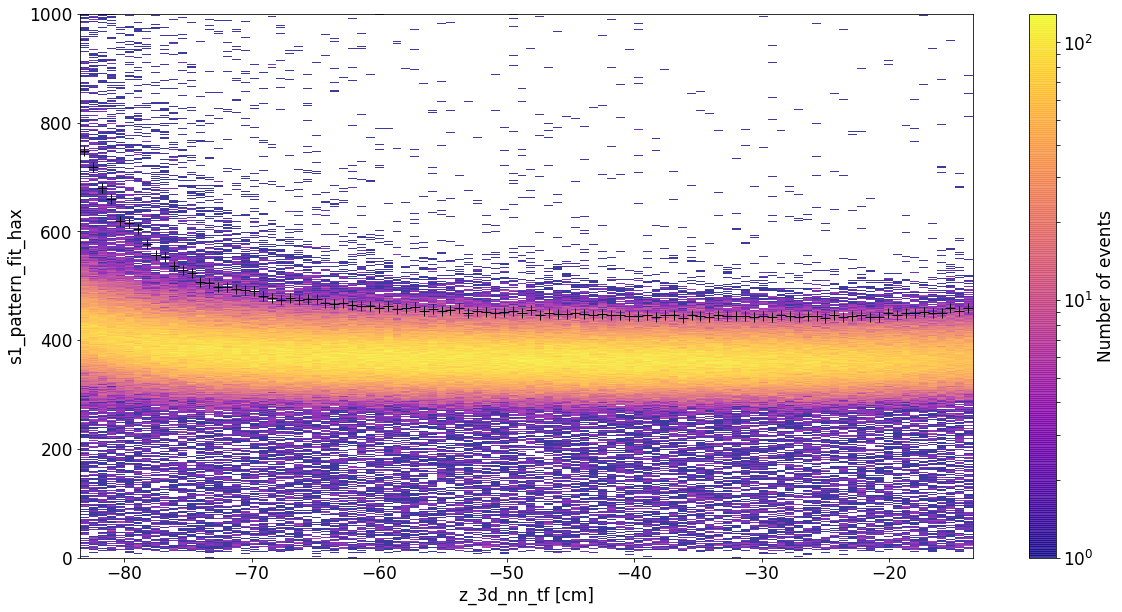

In [11]:
hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.8)
plt.plot(xbins_center_z, perc_z, 'k+', ms = 10)
plt.colorbar(label='Number of events')

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_hax')

del hist_z, xbins_z, ybins_z, _

## Fit of the cut

popt_z:  [  4.48526353e+02   4.70652805e-04   1.60511915e-01] 

pcov_z:  [[  4.35291759e-01  -3.56311400e-05   9.07530378e-04]
 [ -3.56311400e-05   1.27034667e-08  -3.32821672e-07]
 [  9.07530378e-04  -3.32821672e-07   8.73192919e-06]]
------ My function ------
######
Degrees of freedom
97
######
Chi2 value
5.5556805091
######
Critical value
119.870939299
######
P value
1.0


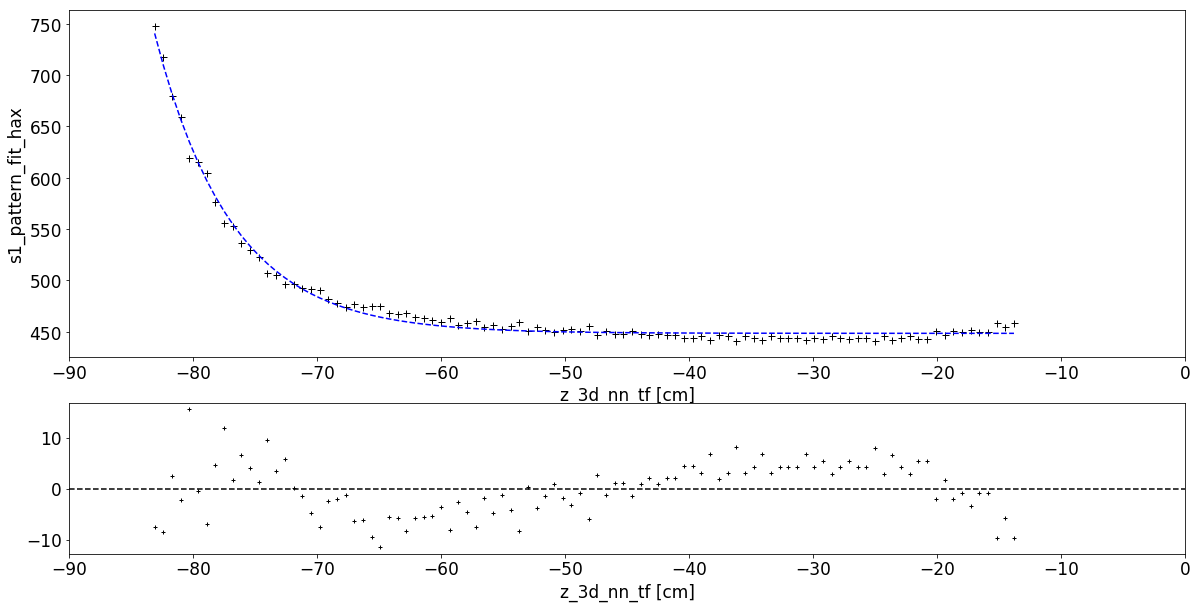

In [12]:
init_z = [4.085e+02,   2.47289420e-04,   2.40508404e-01]

popt_z, pcov_z = curve_fit(exp, xbins_center_z, perc_z, p0=init_z)
print('popt_z: ', popt_z ,'\n\npcov_z: ', pcov_z)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_z, perc_z, 'k+', ms = 7)
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z), 'b--')
plt.xlim(-90,0)

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_z, exp(xbins_center_z, *popt_z) - perc_z, 'k+', ms=4)
plt.hlines(y=0, xmin=-90, xmax = 0 , linestyles='dashed')
plt.xlim(-90,0)
plt.xlabel('z_3d_nn_tf [cm]')

p_ , chi2_ = compute_chi2_p_2(perc_z,exp(xbins_center_z, *popt_z), len(popt_z))

### Cut

In [13]:
data_cut_z = data.copy()
data_cut_z['CutS1PF_z'] = (data_cut_z['s1_pattern_fit_hax'] < exp(data_cut_z['z_3d_nn_tf'], *popt_z))
data_cut_z = hax.cuts.selection(data_cut_z, data_cut_z['CutS1PF_z'] == True)

Unnamed selection: 20492 rows removed (97.63% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


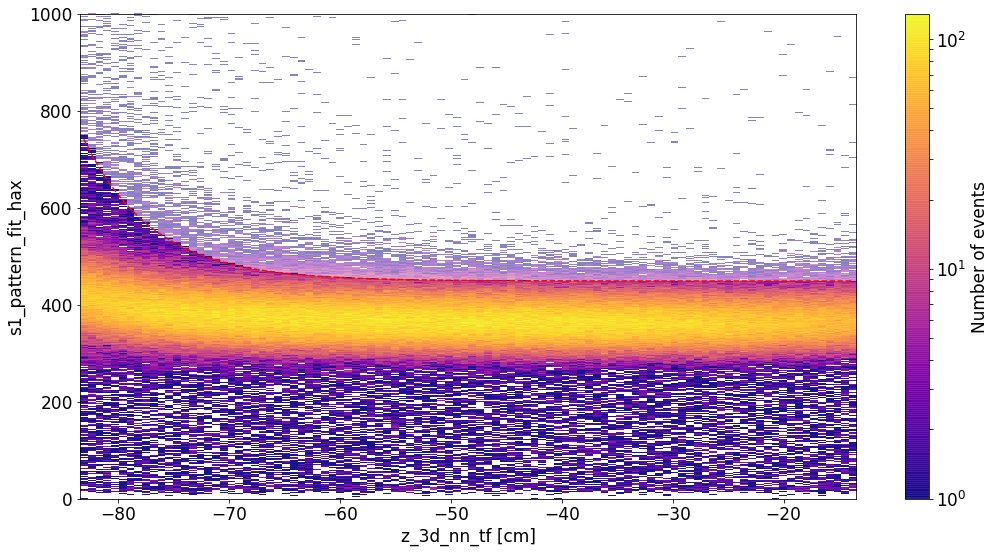

In [14]:
y = []
for i in range(len(xbins_center_z)):
    y.append(exp(xbins_center_z[i], *popt_z))

plt.figure(figsize=(15,8))
hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.5)
hist_z_cut, xbins_z_cut, ybins_z_cut, _ = plt.hist2d(data_cut_z['z_3d_nn_tf'], 
                                         data_cut_z['s1_pattern_fit_hax'],
                                         bins=(100,1000), 
                                         range=((-83.45, -13.45), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.9)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_z, y, 'r--', label = 'S1 Pattern Likelihood Cut')
#plt.legend(loc='best')
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()
plt.show()
hist_z[np.isnan(hist_z)] = 0
hist_z_cut[np.isnan(hist_z_cut)] = 0

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


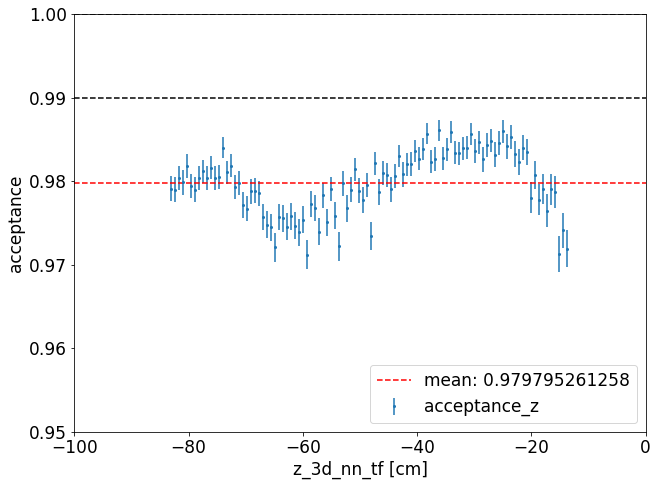

In [15]:
bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_z_cut[i].sum()/hist_z[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_z[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

plt.figure(figsize=(10.24, 7.68))

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.95, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

del bin_centers_acceptance_z, acceptance_z, sigma_z
del hist_z, xbins_z, ybins_z
del hist_z_cut, xbins_z_cut, ybins_z_cut
del Acceptance_z, tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


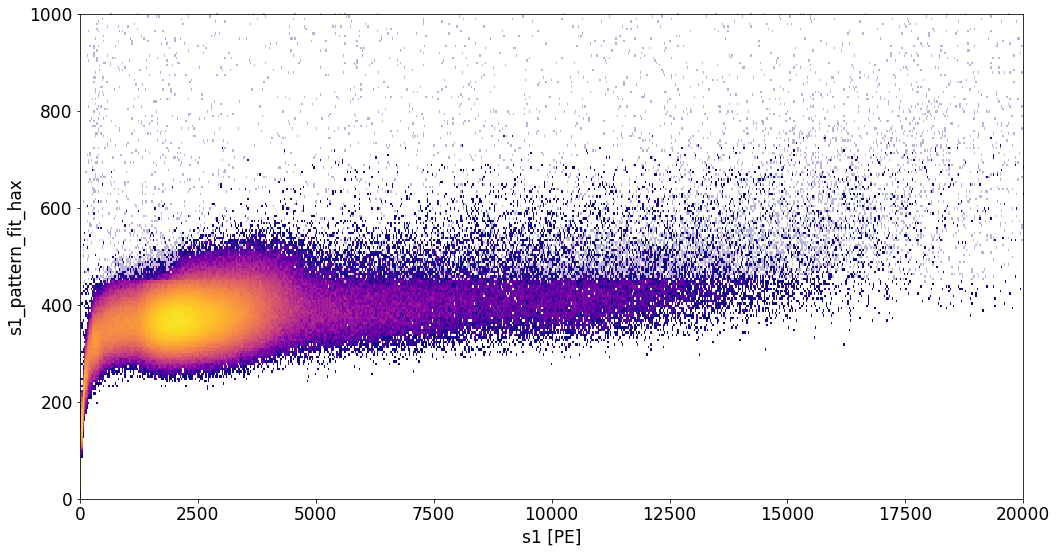

In [16]:
plt.figure(figsize=(15,8))
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
plt.hist2d(data_cut_z['s1'], data_cut_z['s1_pattern_fit_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
#plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


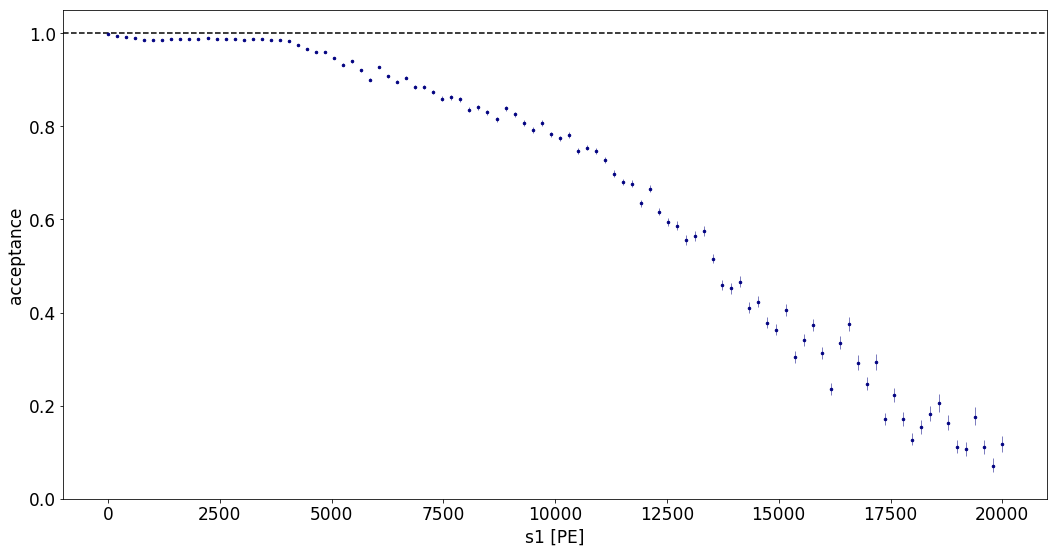

In [17]:
Bins=100
hist_range=([0, 2e4])  
binn=np.linspace(0,2e4,Bins)
fig = plt.figure(figsize=(15, 8))
acceptance(data.s1, data_cut_z.s1)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s1 [PE]')
plt.legend(loc='best')
#plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

## On S1

In [18]:
data = data_cut_z.copy()

100%|██████████| 10/10 [00:00<00:00, 11.80it/s]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


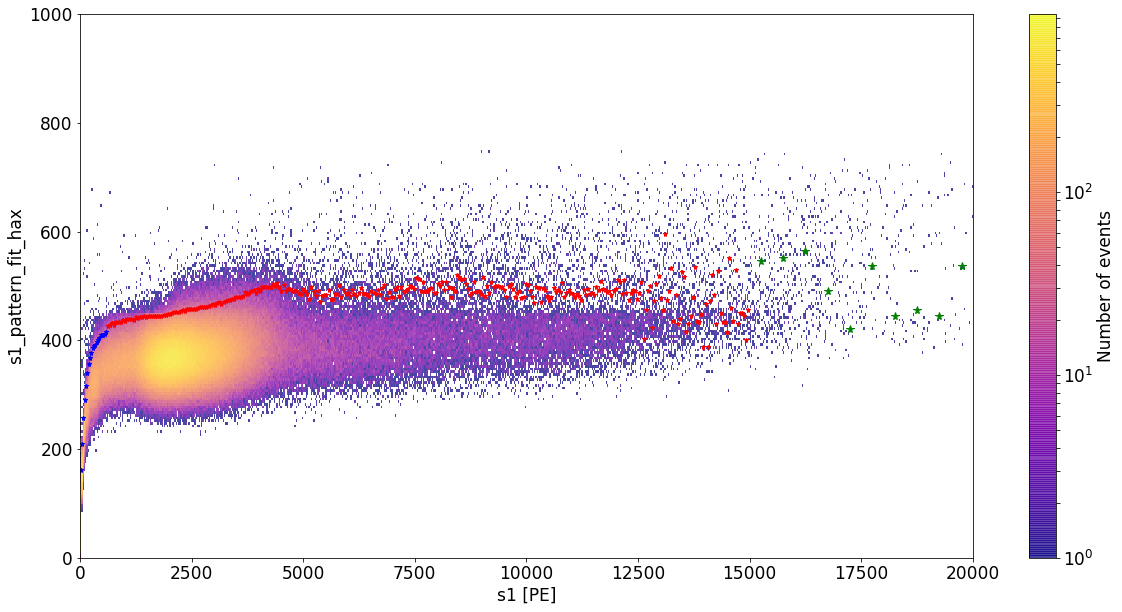

In [19]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (20, 200), 
                                   range=((0,600), (0,1000))
                                   )
ybins_center_1 = [0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)]
xbins_center_1 = [0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)]

perc_1 = np.empty(len(xbins_center_1))
for i in tqdm(range(len(hist_1))):
    perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

hist_2, xbins_2, ybins_2 = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (300, 200), 
                                   range=((600,1.5e4), (0,1000))
                                   )
ybins_center_2 = [0.5*(ybins_2[i]+ybins_2[i+1]) for i in range(len(ybins_2)-1)]
xbins_center_2 = [0.5*(xbins_2[i]+xbins_2[i+1]) for i in range(len(xbins_2)-1)]

perc_2 = np.empty(len(xbins_center_2))
for i in tqdm(range(len(hist_2))):
    perc_2[i] = percentile(index = i, hist=hist_2, ybins=ybins_2, xbins=xbins_2, 
                           q=0.99, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_2, perc_valid_2 = dropNaNforFit(xbins_center_2, perc_2)
xbins_center_valid_2, perc_valid_2 = dropNegforFit(xbins_center_valid_2, perc_valid_2)

hist_3, xbins_3, ybins_3 = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (10, 200), 
                                   range=((1.5e4,2e4), (0,1000))
                                   )
ybins_center_3 = [0.5*(ybins_3[i]+ybins_3[i+1]) for i in range(len(ybins_3)-1)]
xbins_center_3 = [0.5*(xbins_3[i]+xbins_3[i+1]) for i in range(len(xbins_3)-1)]

perc_3 = np.empty(len(xbins_center_3))
for i in tqdm(range(len(hist_3))):
    perc_3[i] = percentile(index = i, hist=hist_3, ybins=ybins_3, xbins=xbins_3, 
                           q=0.98, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_3, perc_valid_3 = dropNaNforFit(xbins_center_3, perc_3)
xbins_center_valid_3, perc_valid_3 = dropNegforFit(xbins_center_valid_3, perc_valid_3)

hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (700, 200), 
                                               range=((0,2e4), (0,1000)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 0.75)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_valid_1, perc_valid_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_2, perc_valid_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_3, perc_valid_3, 'g*', lw=2, ms=8)

#plt.xlim(0,2e4)
#plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

xbins_center_valid = np.concatenate((xbins_center_valid_1, xbins_center_valid_2, xbins_center_valid_3))
perc_valid = np.concatenate((perc_valid_1, perc_valid_2, perc_valid_3))

plt.show()

# Fit of the cut

popt_1:  [  2.15567949e+01   3.73746867e+01  -1.17754277e+00   1.29892668e-02] 

pcov_1:  [[  1.13446384e+02  -2.12714339e+01   1.15894808e+00  -1.91578934e-02]
 [ -2.12714339e+01   4.38345827e+00  -2.51646195e-01   4.29975329e-03]
 [  1.15894808e+00  -2.51646195e-01   1.49507725e-02  -2.61683922e-04]
 [ -1.91578934e-02   4.29975329e-03  -2.61683922e-04   4.66480012e-06]]
------ My function ------
######
Degrees of freedom
26
######
Chi2 value
414.119676154
######
Critical value
37.6524841335
######
P value
0.0

popt_2:  [  4.04890332e+02   2.94875900e-02  -2.93307586e-06   8.40845997e-11] 

pcov_2:  [[  5.83428640e+01  -2.28060514e-02   2.43553858e-06  -7.65579113e-11]
 [ -2.28060514e-02   1.02197124e-05  -1.16958433e-09   3.84271370e-14]
 [  2.43553858e-06  -1.16958433e-09   1.40735466e-13  -4.80660615e-18]
 [ -7.65579113e-11   3.84271370e-14  -4.80660615e-18   1.69874330e-22]]
------ My function ------
######
Degrees of freedom
296
######
Chi2 value
2798.64915436
######
Critical val

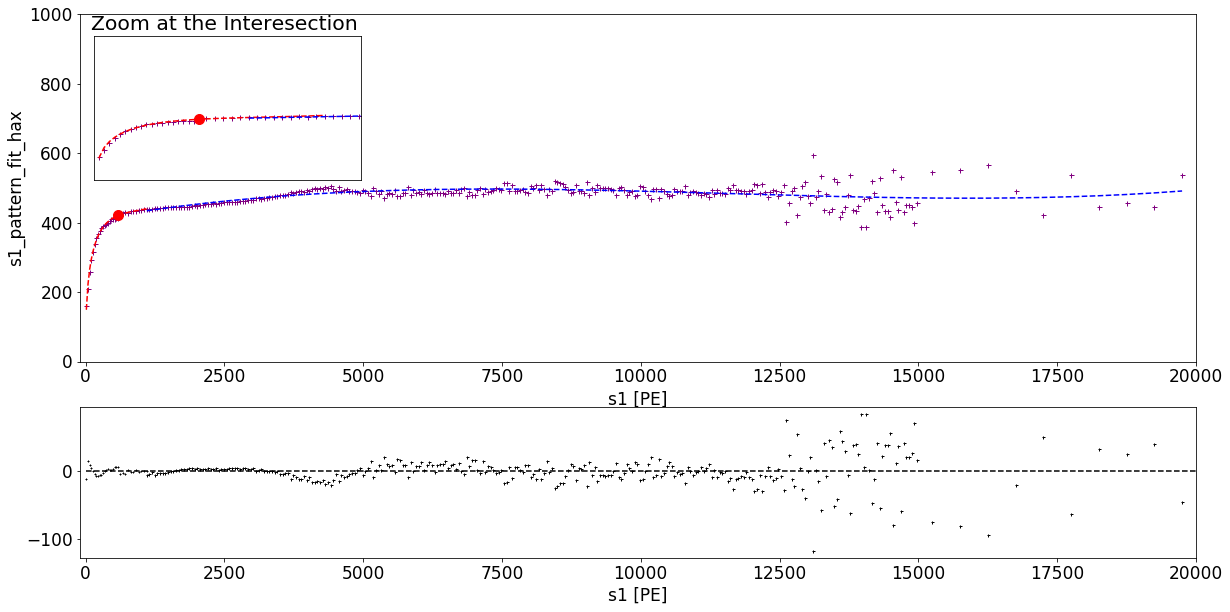

In [20]:
init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1, pcov_1 = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid[:30], perc_valid[:30], p0=init_1)
print('popt_1: ', popt_1 ,'\n\npcov_1: ', pcov_1)
p_1 , chi2_1 = compute_chi2_p_2(perc_valid[:30], 
                                S1PatternLikelihoodProfile_old_2(perc_valid[:30], *popt_1), 
                                len(popt_1))

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]

popt_2, pcov_2 = curve_fit(poly3, xbins_center_valid[30:], perc_valid[30:], p0=init_2)
print('\npopt_2: ',popt_2, '\n\npcov_2: ', pcov_2)
p_2 , chi2_2 = compute_chi2_p_2(perc_valid[30:], 
                                poly3(perc_valid[30:], *popt_2), 
                                len(popt_2))

idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid, *popt_1) - \
                                  poly3(xbins_center_valid, *popt_2)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1), 'r--')
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.axes([0.135, 0.65, .185, .2], facecolor='w')
plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:35], *popt_1), 'r--')
plt.plot(xbins_center_valid[25:], poly3(xbins_center_valid[25:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-10, 15e2)
plt.ylim(0,1000)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1)-perc_valid[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2)-perc_valid[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)
plt.xlabel('s1 [PE]')

plt.show()

In [21]:
xbins_center_valid[idx]

array([ 585.])

In [22]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_hax'] < S1PatternLikelihoodProfile_old_2(data_cut['s1'], *popt_1))*(data_cut['s1']<xbins_center_valid[idx][0]))
                      +((data_cut['s1_pattern_fit_hax'] < poly3(data_cut['s1'], *popt_2))*(data_cut['s1']>=xbins_center_valid[idx][0])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 13687 rows removed (98.38% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


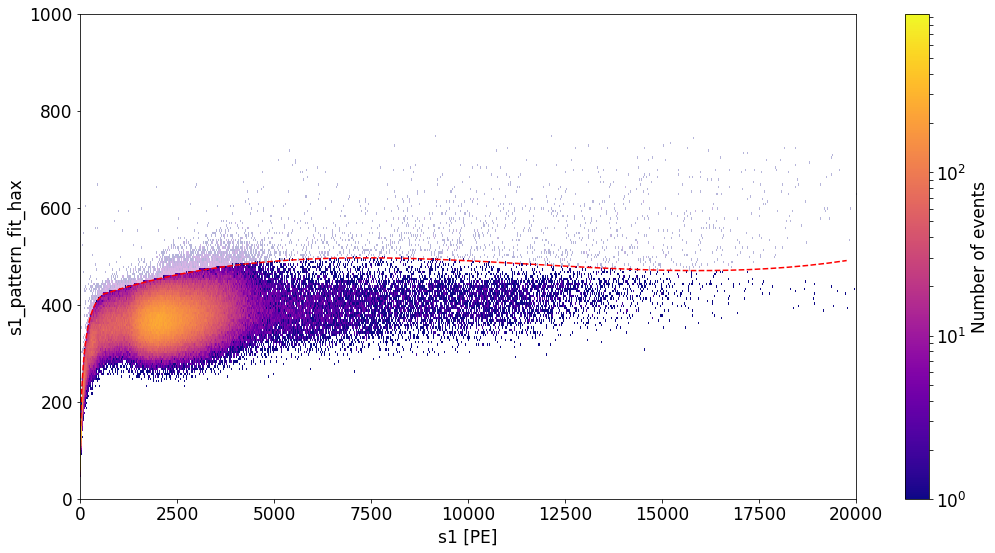

In [23]:
y_valid = []
for i in range(len(xbins_center_valid)):
    y_valid.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid[i], *popt_1))*(xbins_center_valid[i]<xbins_center_valid[idx][0]) + \
                 (poly3(xbins_center_valid[i], *popt_2))*(xbins_center_valid[i]>=xbins_center_valid[idx][0]))

plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], 
                                   bins = (2000, 200), 
                                   range=((0,2e4), (0,1000)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                   cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_hax'], 
                                               bins = (2000, 200), 
                                               range=((0,2e4), (0,1000)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
#plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [24]:
len(data_cut)/len(data), hist_cut.sum()/hist.sum()

(0.9837687133559759, 0.98376871335597593)

In [25]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_ = (xbins_cut[i+1] + xbins_cut[i])/2.
    acc = hist_cut[i].sum()/hist[i].sum()
    sig = np.sqrt(acc*(1-acc)/hist[i].sum())
    if np.isnan(acc)==False and acc!=0:
        bin_centers_acceptance.append(bin_)
        acceptance.append(acc)
        sigma.append(sig)
        print(bin_, acc, sig)
            
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
#acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
#sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(sigma)

print(acceptance_mean)

5.0 1.0 0.0
15.0 0.994817432273 0.0011020602527
25.0 0.995942571785 0.00112304282397
35.0 0.996907614998 0.00109163140538
45.0 0.998588899341 0.000814124330733
55.0 0.997862105826 0.00106780382788
65.0 0.997473152243 0.00126182662917
75.0 0.996438746439 0.00158980258104
85.0 0.993328391401 0.00221643872484
95.0 0.986257073565 0.00331016640416
105.0 0.987931034483 0.00320604299945
115.0 0.985754985755 0.0036517559832
125.0 0.971844660194 0.00515418734907
135.0 0.981441048035 0.00445924255653
145.0 0.980023501763 0.00479637516817
155.0 0.962962962963 0.0067490404147
165.0 0.969173859433 0.00606945919551
175.0 0.96812749004 0.00640142881928
185.0 0.976839237057 0.00555187844131
195.0 0.979680696662 0.00537510647277
205.0 0.961820851689 0.00734322196842
215.0 0.95867768595 0.00738686762021
225.0 0.978580990629 0.00529709518644
235.0 0.963687150838 0.00699103837243
245.0 0.965789473684 0.00659347426637
255.0 0.972868217054 0.00583976935095
265.0 0.962726304579 0.00618186973056
275.0 0.96569

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


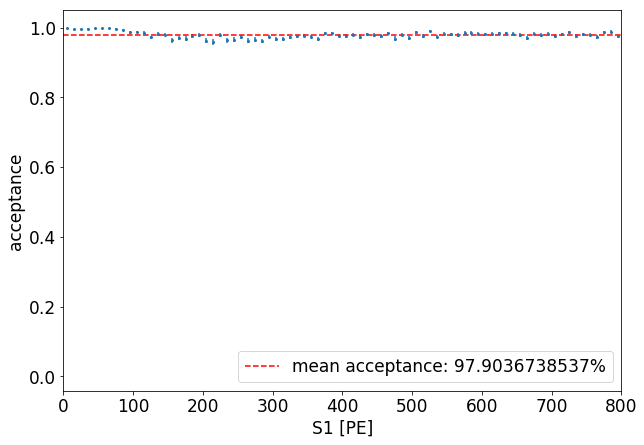

In [26]:
acceptance_mean = np.mean(acceptance[:80])
acceptance_median = np.median(acceptance[:80])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=8e2, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 800)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

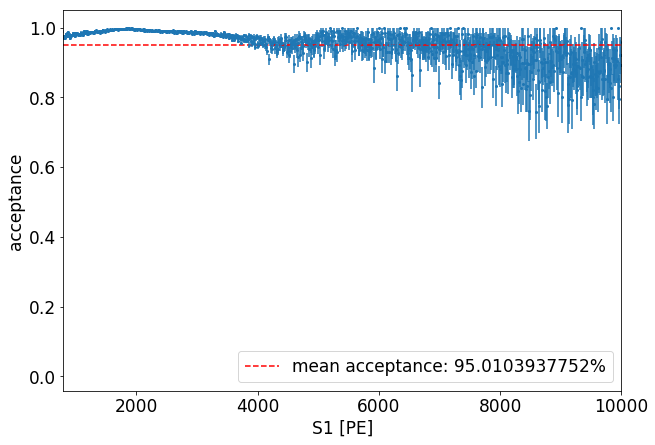

In [27]:
acceptance_mean = np.mean(acceptance[80:1000])
acceptance_median = np.median(acceptance[80:1000])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=8e2, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(8e2, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

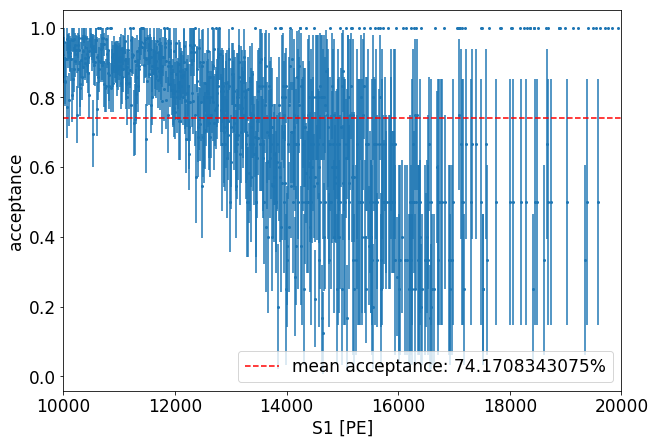

In [28]:
acceptance_mean = np.mean(acceptance[1000:])
acceptance_median = np.median(acceptance[1000:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

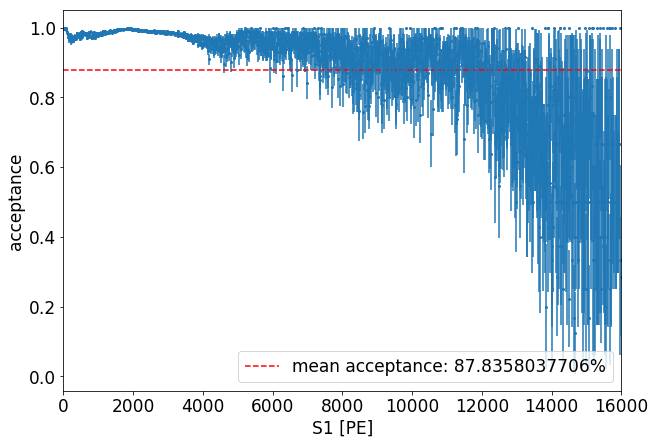

In [29]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance[:1600])
acceptance_median = np.median(acceptance[:1600])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 1.6e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [30]:
def acceptance(data_before, data_after):
    after, bins=np.histogram(data_after ,bins=Bins, range=hist_range)
    before, bins=np.histogram(data_before ,bins=Bins, range=hist_range)

    acceptance = after/before
    error = proportion_confint(after, before, method=binomial_error_method, alpha=binomial_alpha)
    err_low = error[0]
    err_high = error[1]
    yerr_low, yerr_high = (acceptance - err_low, err_high - acceptance)
    err = (yerr_low, yerr_high)

    plt.errorbar(binn, acceptance, err,0, marker='.', markersize=5, linestyle="", linewidth=0.5, color='navy')
    plt.axhline(y=1, color='k',linestyle='--')
    plt.ylabel('acceptance')
    plt.ylim(0,1.05)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


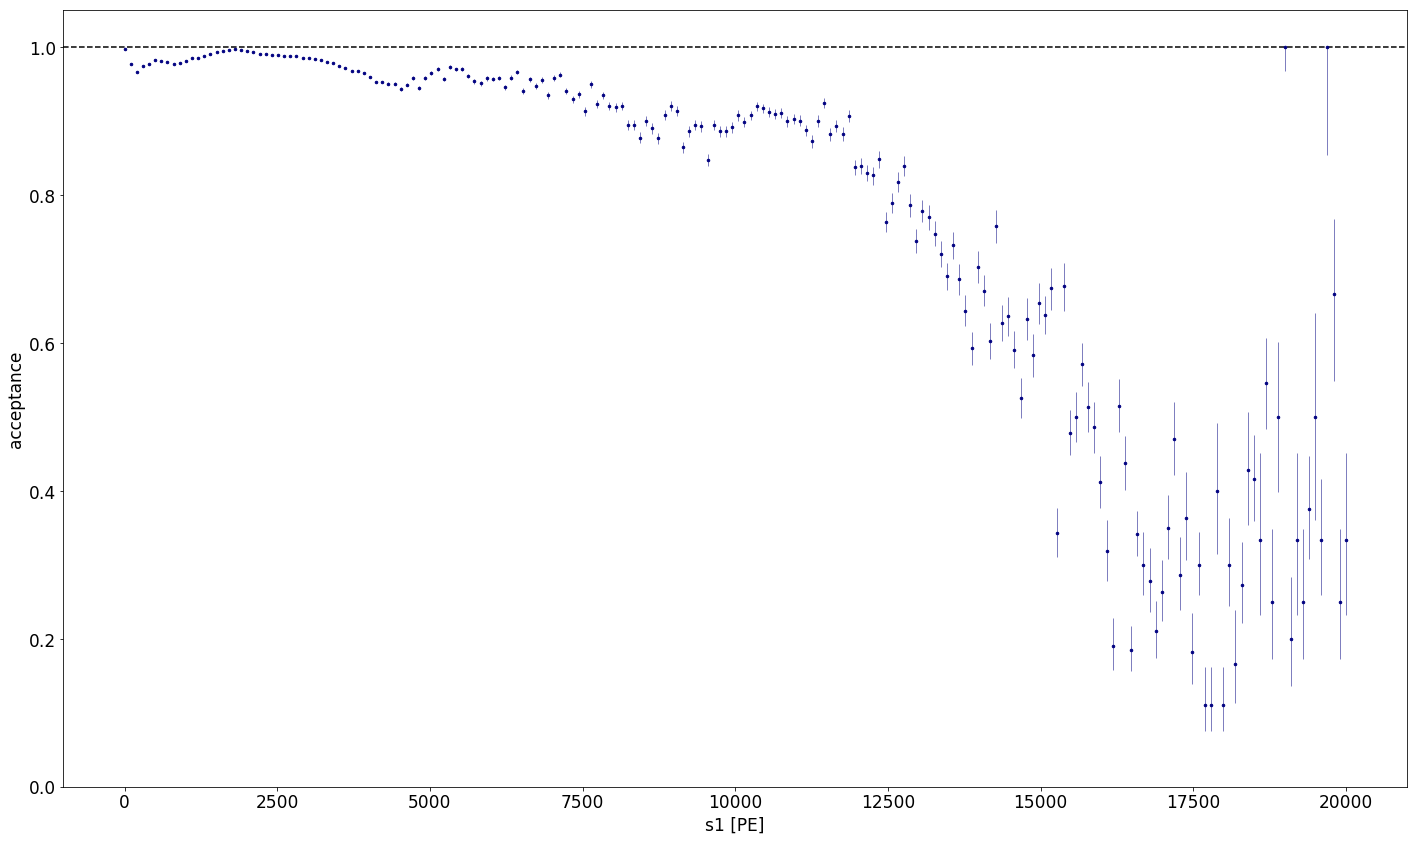

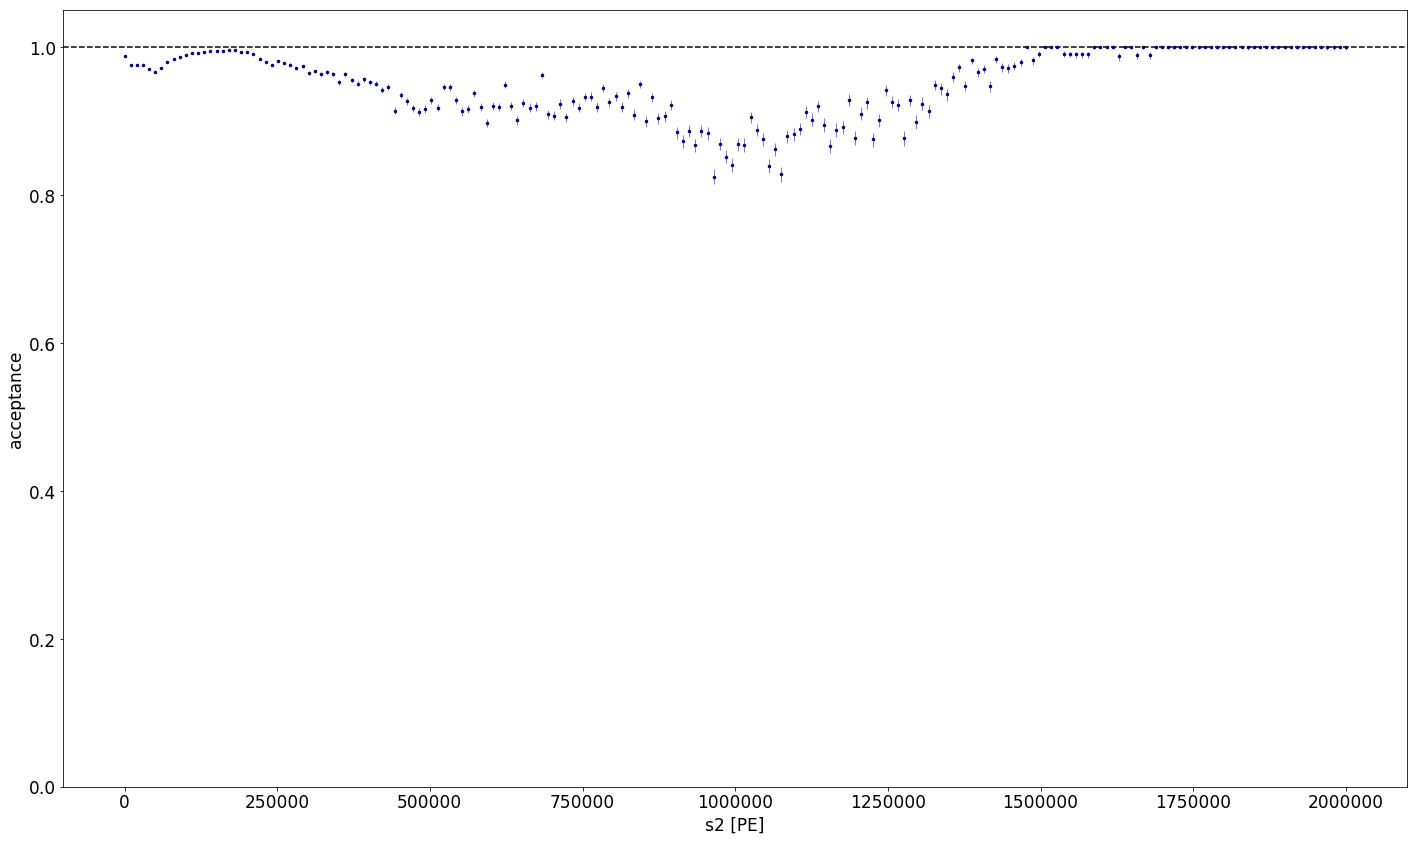

In [31]:
Bins=200
hist_range=([0,2e4])  
binn=np.linspace(0,2e4,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(data['s1'], data_cut['s1'])
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s1 [PE]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Bins=200
hist_range=([0,2e6])  
binn=np.linspace(0,2e6,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(data['s2'], data_cut['s2'])
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.xlabel('s2 [PE]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Quality study

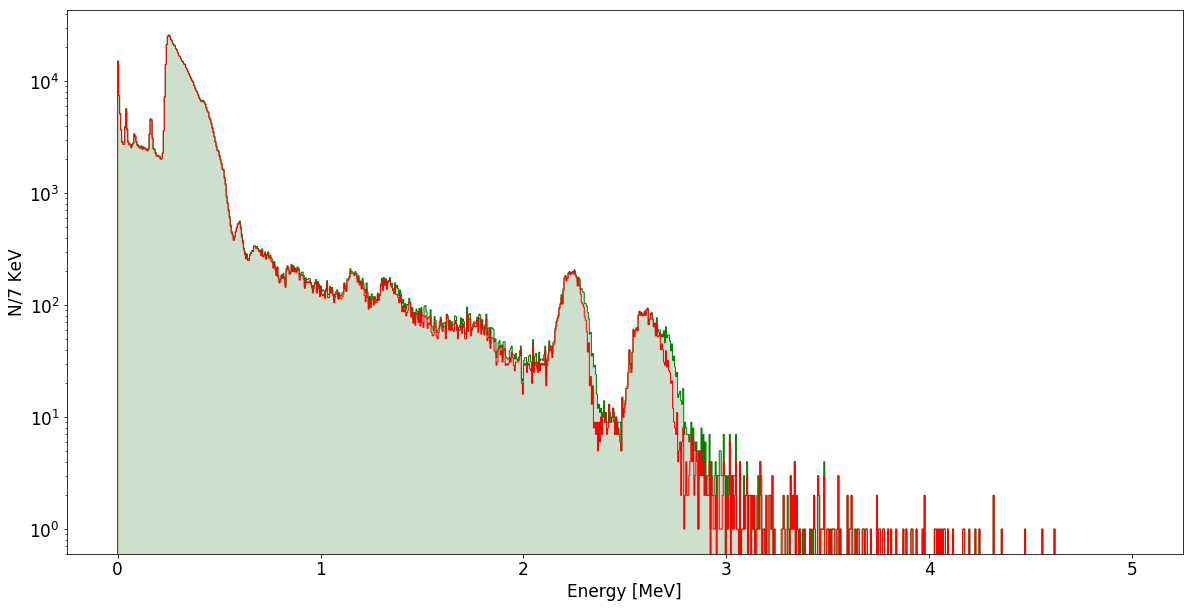

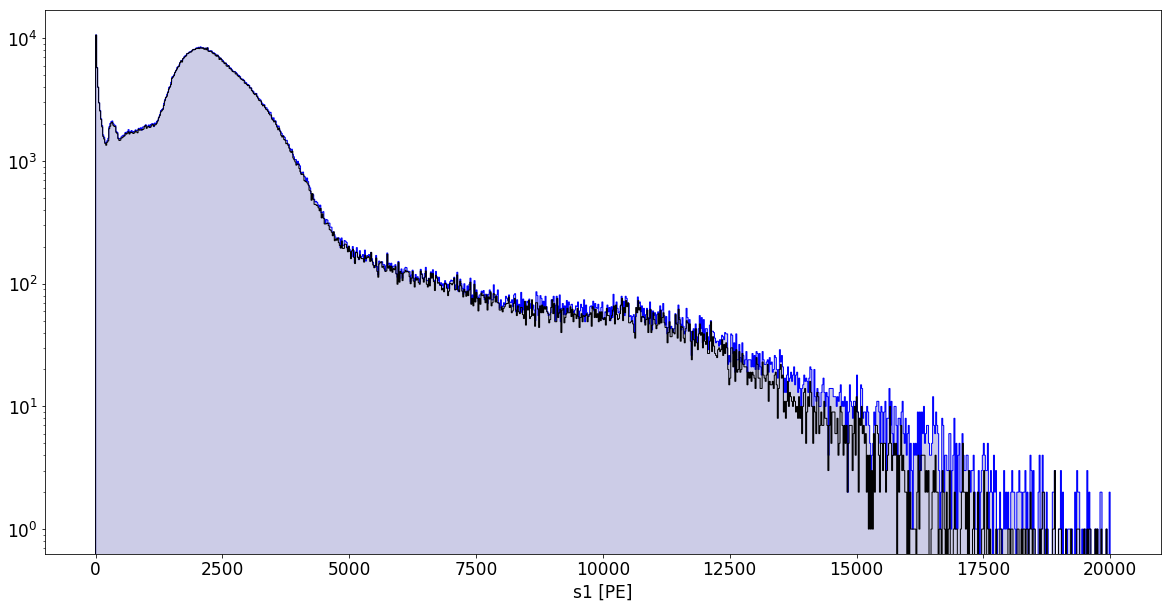

In [32]:
plt.hist(data['CES']/10**6, bins = (1000), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.2)
plt.hist(data['CES']/10**6, bins = (1000), 
         range=(0, 5), 
         histtype='step', color='green',
         alpha = 1)
plt.hist(data_cut['CES']/10**6, bins = (1000), 
         range=(0, 5), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N/7 KeV')
plt.yscale('log')
plt.show()

plt.hist(data['s1'], bins = (1000), 
         #range=(0, 5), 
         histtype='bar', color='darkblue',
         alpha = 0.2)
plt.hist(data['s1'], bins = (1000), 
         #range=(0, 5), 
         histtype='step', color='blue',
         alpha = 1)
plt.hist(data_cut['s1'], bins = (1000), 
         #range=(0, 5), 
         histtype='step', color='black',
         alpha = 1)
plt.xlabel('s1 [PE]')
#plt.ylabel('N/7 KeV')
plt.yscale('log')
plt.show()


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


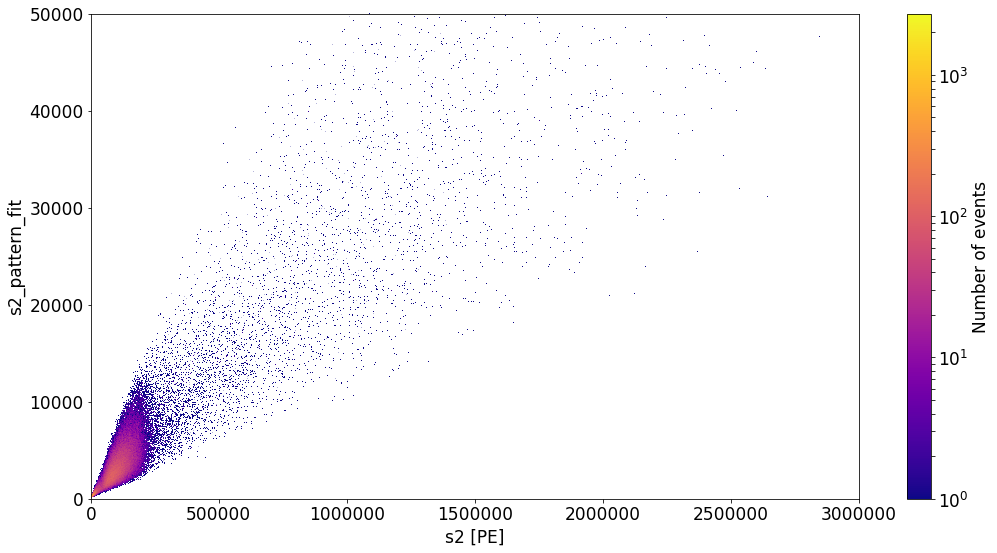

In [33]:
plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s2'], data['s2_pattern_fit'], 
                                   bins = (2000, 2000), 
                                   range=((0,3e6), (0,5e4)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                   cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s2'], data_cut['s2_pattern_fit'], 
                                               bins = (2000, 2000), 
                                               range=((0,3e6), (0,5e4)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
#plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
#plt.legend(loc='best')
plt.xlabel('s2 [PE]')
plt.ylabel('s2_pattern_fit')

plt.tight_layout()
plt.show()

## Acceptance study on xyz

In [34]:
data_cut_2 = data_cut.copy()
data_cut_2['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(data_cut_2['y_3d_nn_tf']/data_cut_2['x_3d_nn_tf'])
tmp = data_cut_2.copy()
z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2 = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
tmp = data.copy()
z1_white = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2_white = tmp[(tmp['z_3d_nn_tf']>-70) & (tmp['z_3d_nn_tf']<=-30)]
z3_white = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-70)]
del tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


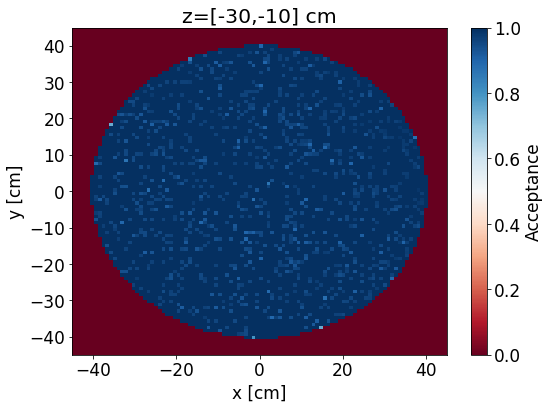

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


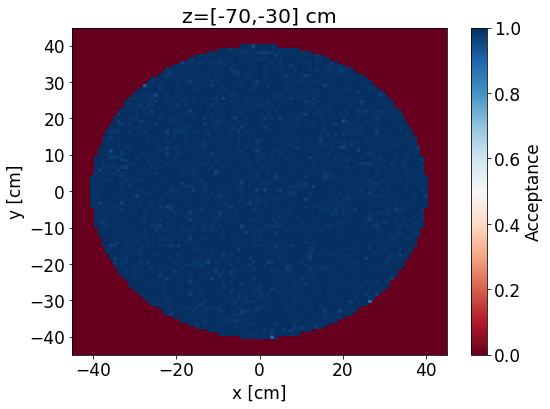

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide


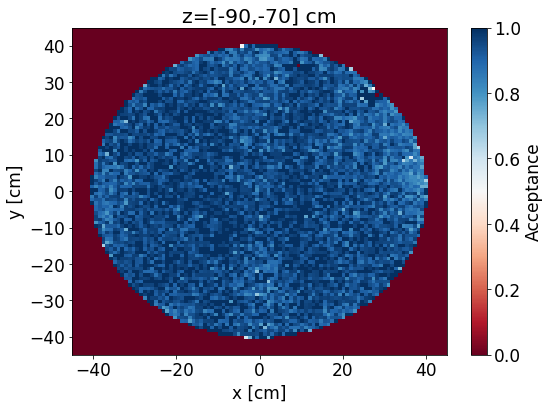

In [35]:
plt.figure(figsize=(8,6))
hist_data_1, x_data_1, y_data_1 = np.histogram2d(z1_white['x_3d_nn_tf'], z1_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_1, x_cut_1, y_cut_1 = np.histogram2d(z1['x_3d_nn_tf'], z1['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_1 = hist_cut_1/hist_data_1
c_1 = plt.pcolor(x_data_1, y_data_1, Acceptance_xy_1, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_1, label='Acceptance')
plt.title('z=[-30,-10] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
hist_data_2, x_data_2, y_data_2 = np.histogram2d(z2_white['x_3d_nn_tf'], z2_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_2, x_cut_2, y_cut_2 = np.histogram2d(z2['x_3d_nn_tf'], z2['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_2 = hist_cut_2/hist_data_2
c_2 = plt.pcolor(x_data_2, y_data_2, Acceptance_xy_2, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_2, label='Acceptance')
plt.title('z=[-70,-30] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
hist_data_3, x_data_3, y_data_3 = np.histogram2d(z3_white['x_3d_nn_tf'], z3_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_3, x_cut_3, y_cut_3 = np.histogram2d(z3['x_3d_nn_tf'], z3['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_3 = hist_cut_3/hist_data_3
c_3 = plt.pcolor(x_data_3, y_data_3, Acceptance_xy_3, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_3, label='Acceptance')
plt.title('z=[-90,-70] cm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:68: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:111: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:112: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/statsmodels/stats/proportion.py:113: RuntimeWarning: divide by zero encountered in true_divide
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))
/project/lgrandi/anaconda3

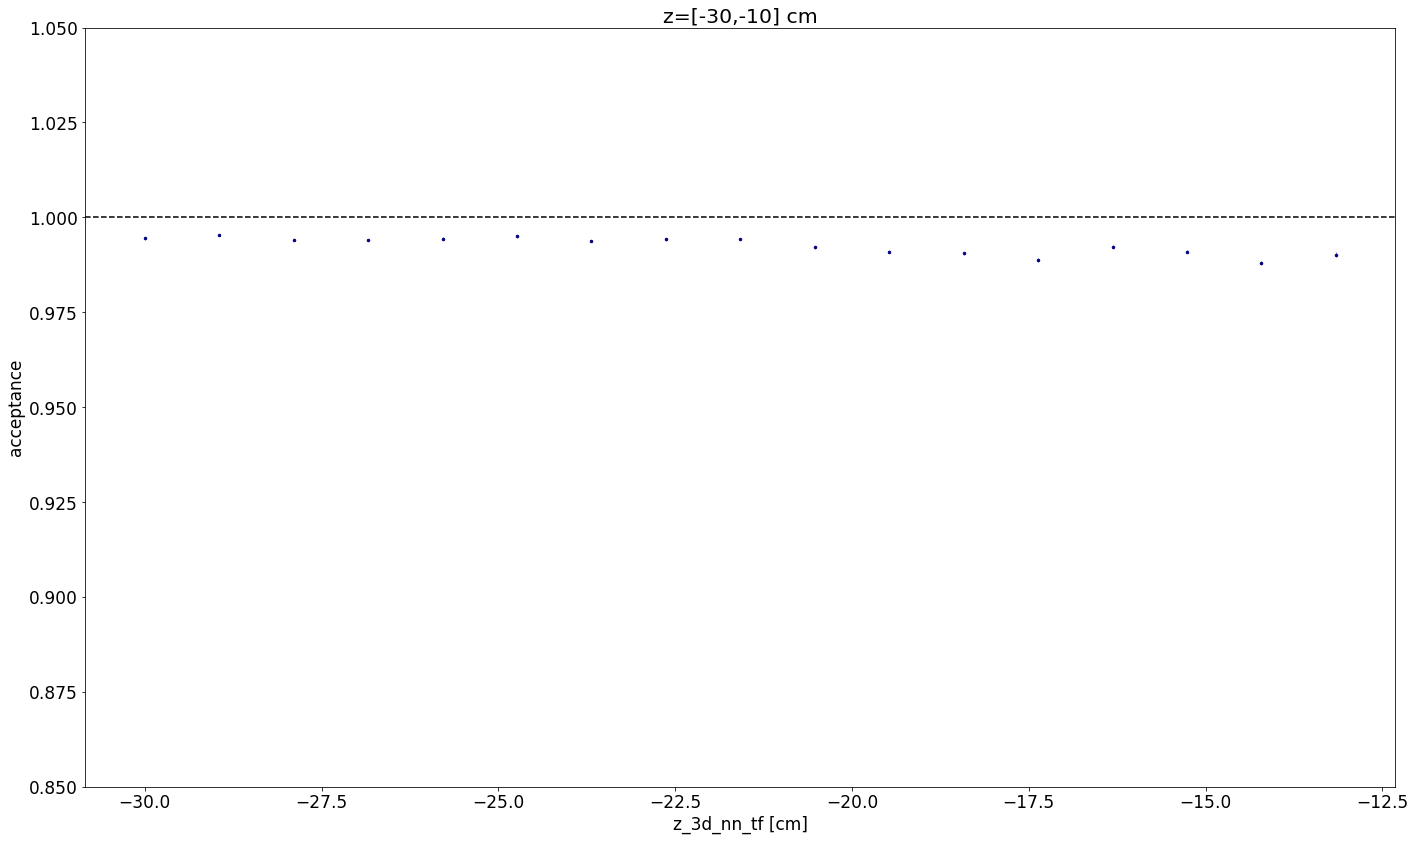

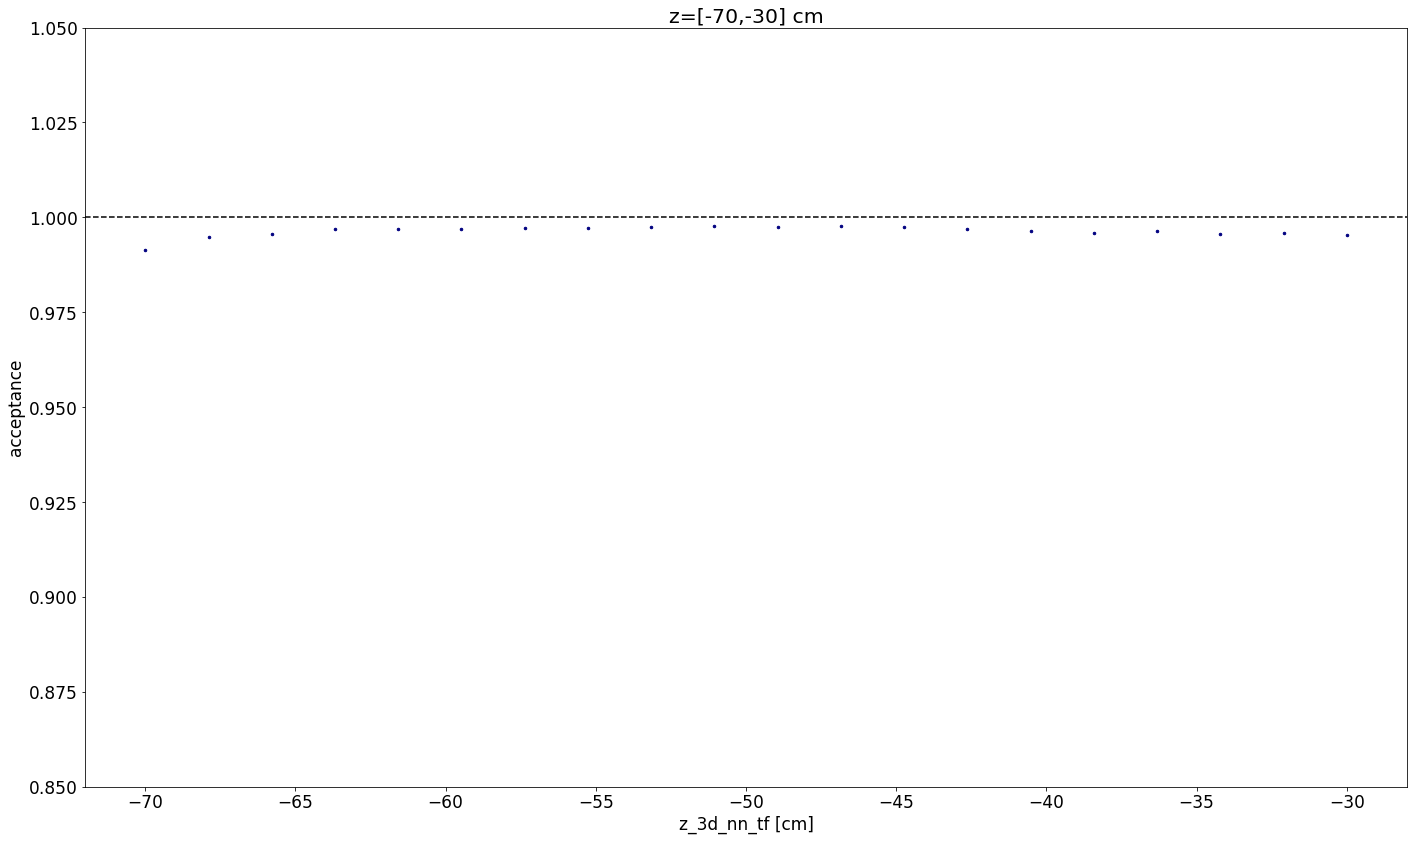

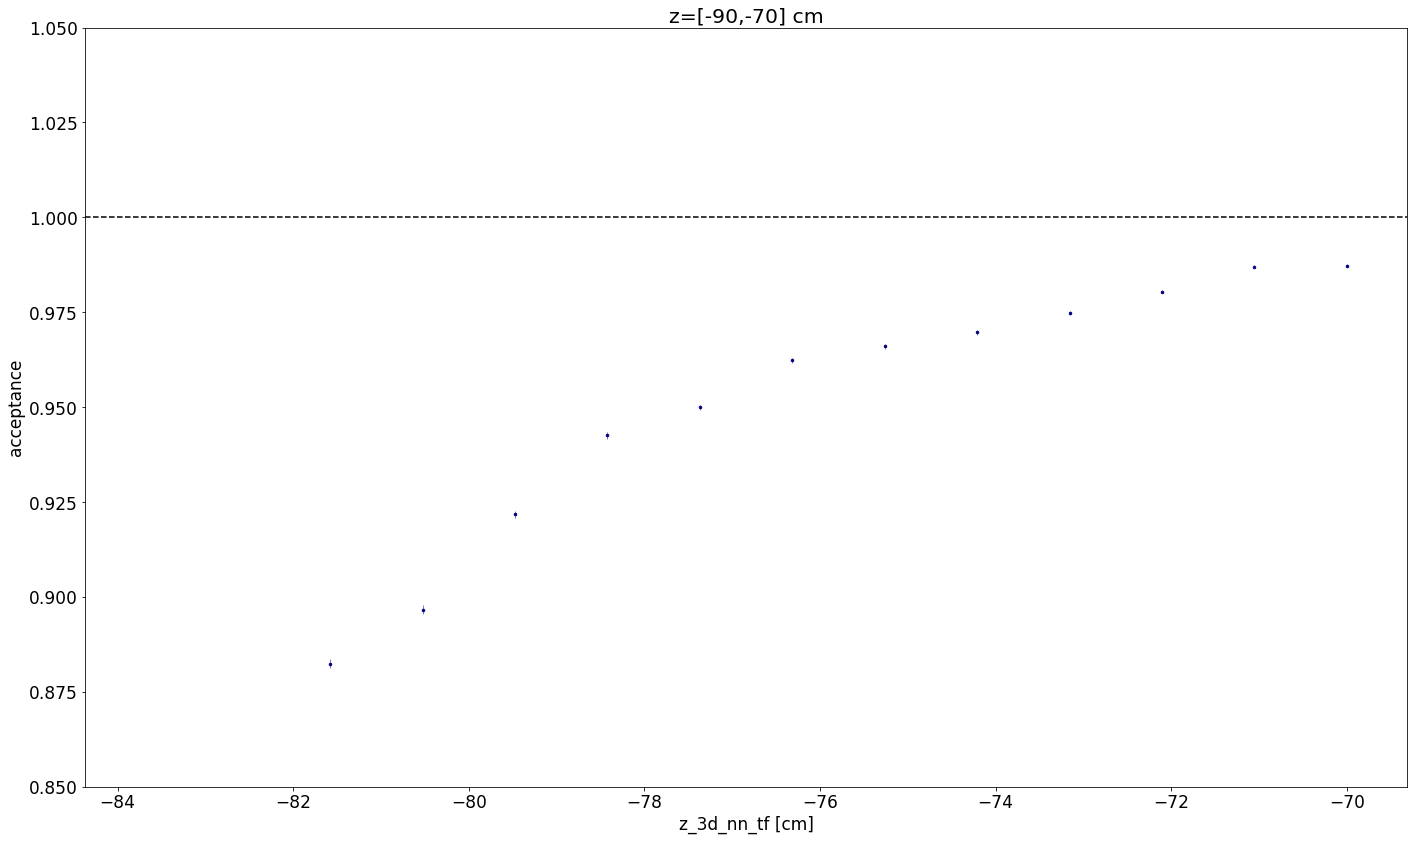

In [36]:
plt.figure(figsize=(8,6))
Bins=20
hist_range=([-30, -10])  
binn=np.linspace(-30,-10,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z1_white.z_3d_nn_tf, z1.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-30,-10] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
Bins=20
hist_range=([-70, -30])  
binn=np.linspace(-70,-30,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z2_white.z_3d_nn_tf, z2.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-70,-30] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
Bins=20
hist_range=([-90, -70])  
binn=np.linspace(-90,-70,Bins)
fig = plt.figure(figsize=(20, 12))
acceptance(z3_white.z_3d_nn_tf, z3.z_3d_nn_tf)
#plt.axvline(x=36.94, color='r',linestyle='--', label='1T FV radius')
plt.title('z=[-90,-70] cm')
plt.xlabel('z_3d_nn_tf [cm]')
plt.legend(loc='best')
plt.ylim(0.85,1.05)
plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


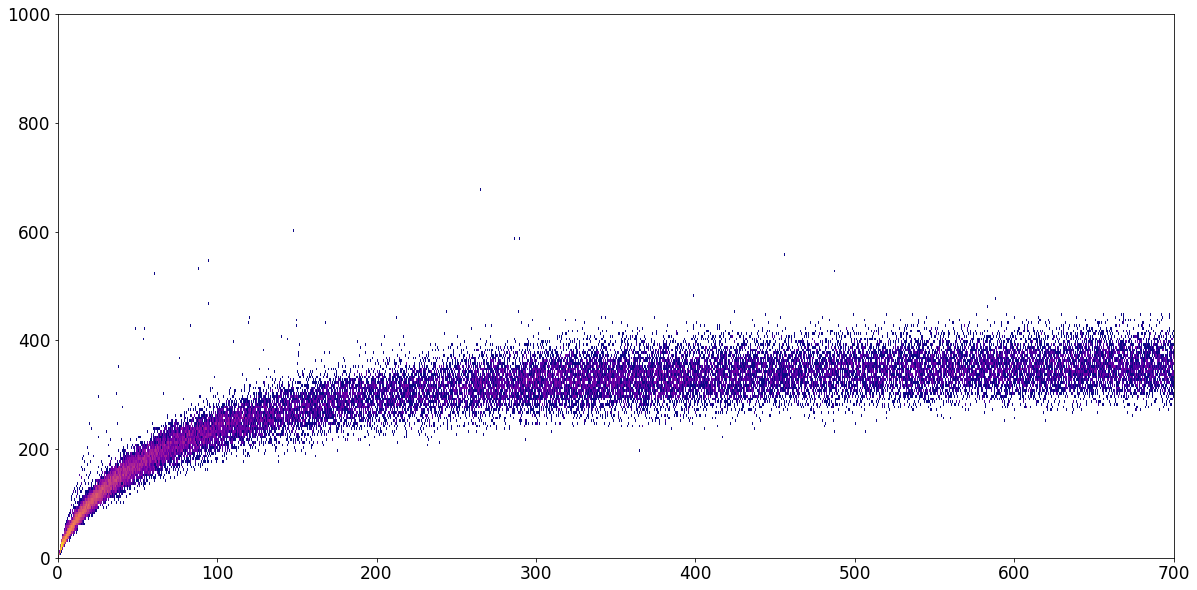

NameError: name 'data2' is not defined

In [37]:
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], 
                                   bins = (2000, 200), 
                                   range=((0,700), (0,1000)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                   cmin = 1,alpha = 1)
plt.show()

hist, xbins, ybins, _ = plt.hist2d(data2['s1'], data2['s1_pattern_fit_hax'], 
                                   bins = (2000, 200), 
                                   range=((0,700), (0,1000)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                   cmin = 1,alpha = 1)
plt.show()

hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_hax'], 
                                               bins = (2000, 200), 
                                               range=((0,700), (0,1000)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                               cmin = 1,alpha = 1)
plt.show()